<a href="https://colab.research.google.com/github/katterine2558/ods-semantic-hub/blob/main/ods_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SOLUCIÓN MICROPROYECTO 2

Por: *Leonardo Almanza y Katerine Arias*

## 1. Importar librerías
En esta etapa inicial se realiza la importación de las librerías esenciales para desarrollar una solución automatizada de clasificación de textos según los 17 Objetivos de Desarrollo Sostenible (ODS). Se incluyen herramientas fundamentales para manipulación y análisis de datos (Pandas, NumPy), procesamiento de lenguaje natural (NLTK, word_tokenize, stopwords, PorterStemmer), extracción de características textuales (CountVectorizer, TfidfVectorizer), implementación de algoritmos de machine learning supervisado (Naive Bayes, Regresión Logística) y  técnicas de reducción de dimensionalidad (PCA, TruncatedSVD). Estas herramientas permiten transformar textos  en representaciones vectoriales mediante el esquema de bolsa de palabras (BOW) con pesado TF-IDF, aplicar técnicas de reducción de dimensionalidad para manejar la alta dimensionalidad del espacio de entrada, y construir modelos de clasificación automática.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# NLTK para procesamiento de texto
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk

# Scikit-learn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [ ]:
try:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('punkt_tab')
    print("Recursos NLTK descargados exitosamente")
except:
    print("Algunos recursos de NLTK no se pudieron descargar")

print("Librerías importadas exitosamente")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Recursos NLTK descargados exitosamente
Librerías importadas exitosamente


## 2. Carga y Exploración de Datos

=== INFORMACIÓN DEL DATASET ===
Forma del dataset: (9656, 2)
Columnas: ['textos', 'ODS']

Primeras 5 filas:
                                              textos  ODS
0  "Aprendizaje" y "educación" se consideran sinó...    4
1  No dejar clara la naturaleza de estos riesgos ...    6
2  Como resultado, un mayor y mejorado acceso al ...   13
3  Con el Congreso firmemente en control de la ju...   16
4  Luego, dos secciones finales analizan las impl...    5

Distribución de clases (ODS):
ODS
1      505
2      369
3      894
4     1025
5     1070
6      695
7      787
8      446
9      343
10     352
11     607
12     312
13     464
14     377
15     330
16    1080
Name: count, dtype: int64

Valores nulos:
textos    0
ODS       0
dtype: int64


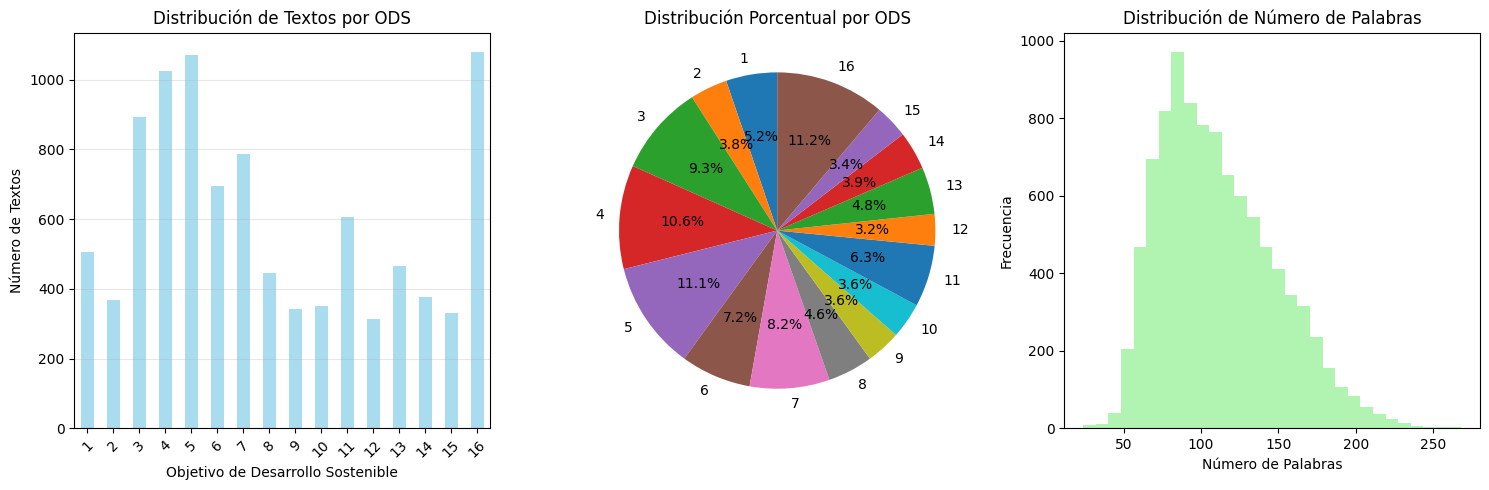


=== ESTADÍSTICAS DE TEXTO ===
Longitud promedio de caracteres: 709.0
Longitud promedio de palabras: 111.0
Texto más corto: 143 caracteres
Texto más largo: 1977 caracteres


In [ ]:
# Cargar datos
df = pd.read_excel('train_textos.xlsx')

print("=== INFORMACIÓN DEL DATASET ===")
print(f"Forma del dataset: {df.shape}")
print(f"Columnas: {list(df.columns)}")
print("\nPrimeras 5 filas:")
print(df.head())

print(f"\nDistribución de clases (ODS):")
ods_counts = df['ODS'].value_counts().sort_index()
print(ods_counts)

# Verificar valores nulos
print(f"\nValores nulos:")
print(df.isnull().sum())

# Visualización básica con matplotlib
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
ods_counts.plot(kind='bar', color='skyblue', alpha=0.7)
plt.title('Distribución de Textos por ODS')
plt.xlabel('Objetivo de Desarrollo Sostenible')
plt.ylabel('Número de Textos')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 3, 2)
plt.pie(ods_counts.values, labels=ods_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribución Porcentual por ODS')

# Estadísticas básicas de texto
df['longitud_texto'] = df['textos'].str.len()
df['num_palabras'] = df['textos'].str.split().str.len()

plt.subplot(1, 3, 3)
plt.hist(df['num_palabras'], bins=30, alpha=0.7, color='lightgreen')
plt.title('Distribución de Número de Palabras')
plt.xlabel('Número de Palabras')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

print(f"\n=== ESTADÍSTICAS DE TEXTO ===")
print(f"Longitud promedio de caracteres: {df['longitud_texto'].mean():.1f}")
print(f"Longitud promedio de palabras: {df['num_palabras'].mean():.1f}")
print(f"Texto más corto: {df['longitud_texto'].min()} caracteres")
print(f"Texto más largo: {df['longitud_texto'].max()} caracteres")

Se encuentran 16 ODS

## 3. Preprocesamiento de Textos
 - **Limpieza**: Normalización de texto para reducir ruido
 - **Tokenización**: División en unidades de análisis
 - **Eliminación de stopwords**: Remoción de palabras sin valor semántico
 - **Stemming**: Reducción a raíces para agrupar variantes

In [ ]:

try:
    stop_words_spanish = set(stopwords.words('spanish'))
except:
    print("Error obtenieno stopwords")

stemmer = PorterStemmer()


In [ ]:

def text_preprocess(text):
    """
    Función de preprocesamiento completa
    Basada en el tutorial de ejemplo pero adaptada para español
    """
    if pd.isna(text):
        return ""

    # Convertir a minúsculas
    text = text.lower()

    # Eliminar caracteres especiales, conservar solo letras y espacios
    text = re.sub(r'[^a-záéíóúñü\s]', ' ', text)

    # Eliminar espacios múltiples
    text = re.sub(r'\s+', ' ', text)

    # Tokenización
    try:
        tokens = word_tokenize(text)
    except:
        tokens = word_tokenize(text)

    # Eliminar stopwords, palabras cortas y aplicar stemming
    tokens = [stemmer.stem(word) for word in tokens
              if word not in stop_words_spanish and len(word) > 2]

    return ' '.join(tokens)

### Aplicar preprocesamiento


In [ ]:

# Aplicar preprocesamiento
print("Aplicando preprocesamiento de textos...")
df['texto_procesado'] = df['textos'].apply(text_preprocess)

# Mostrar ejemplos
print("\n=== EJEMPLOS DE PREPROCESAMIENTO ===")
for i in range(3):
    print(f"\nEjemplo {i+1}:")
    print(f"Original: {df['textos'].iloc[i][:200]}...")
    print(f"Procesado: {df['texto_procesado'].iloc[i][:200]}...")

# Verificar y eliminar textos vacíos
textos_vacios = (df['texto_procesado'].str.len() == 0).sum()
print(f"\nTextos vacíos después del procesamiento: {textos_vacios}")

if textos_vacios > 0:
    df = df[df['texto_procesado'].str.len() > 0].reset_index(drop=True)
    print(f"Dataset después de limpieza: {df.shape}")


Aplicando preprocesamiento de textos...

=== EJEMPLOS DE PREPROCESAMIENTO ===

Ejemplo 1:
Original: "Aprendizaje" y "educación" se consideran sinónimos de escolarización formal. Las organizaciones auxiliares, como las editoriales de educación, las juntas examinadoras y las organizaciones de formació...
Procesado: aprendizaj educación consideran sinónimo escolarización formal organizacion auxiliar editorial educación junta examinadora organizacion formación docent consideran extension acuerdo establecido gobier...

Ejemplo 2:
Original: No dejar clara la naturaleza de estos riesgos puede dar lugar a un exceso de inversión en empresas dependientes del agua y a peticiones de compensación cuando haya que reducir los derechos para evitar...
Procesado: dejar clara naturaleza riesgo pued dar lugar exceso inversión empresa dependient agua peticion compensación reducir derecho evitar compromet calidad agua resultado medioambiental ejemplo fundament evi...

Ejemplo 3:
Original: Como resultado, un